### Expiry Date Recognition

NIM: 2602110986

Nama: Anthonio Obert Lais

Deployment: https://crnn-expiry-date-recognition.streamlit.app/

Dataset: https://felizang.github.io/expdate/

In [19]:
import os
import numpy as np
import tensorflow as tf
import pandas as pd
import json
import matplotlib.pyplot as plt
import os
import cv2 as cv
from tqdm import tqdm
import string
from sklearn.model_selection import train_test_split
from tensorflow.keras.backend import ctc_decode, get_value
import Levenshtein

In [2]:
PATH = '../dataset/Date-Synth/images/'

In [3]:
ANNOTATIONS_PATH = '../dataset/Date-Synth/annotations.json'

with open(ANNOTATIONS_PATH, 'r') as file:
    data = json.load(file)

def get_y_from_json(file: str) -> str:
    return " ".join(annotation['transcription'] for annotation in data[file]['ann'])

In [4]:
get_y_from_json('00001.jpg')

'10 10 2016'

In [5]:
def preprocess_image(image, resize=True):

    image_cv = image.astype(np.uint8)
    
    if len(image_cv.shape) == 2 or image_cv.shape[2] == 1:
        image_cv = cv.cvtColor(image_cv, cv.COLOR_GRAY2BGR)
    elif image_cv.shape[2] == 4:
        image_cv = cv.cvtColor(image_cv, cv.COLOR_RGBA2BGR)

    if(resize):
        image_cv = cv.resize(image_cv, (0, 0), fx=2, fy=2)  

    gray = cv.cvtColor(image_cv, cv.COLOR_BGR2GRAY)
    blurred = cv.GaussianBlur(gray, (5, 5), 0)
    
    thresh = cv.adaptiveThreshold(blurred, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY_INV, 11, 2)

    kernel = cv.getStructuringElement(cv.MORPH_RECT, (2, 2))
    closed = cv.morphologyEx(thresh, cv.MORPH_CLOSE, kernel, iterations=1)
        
    return closed

Loading images:   0%|          | 0/1 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


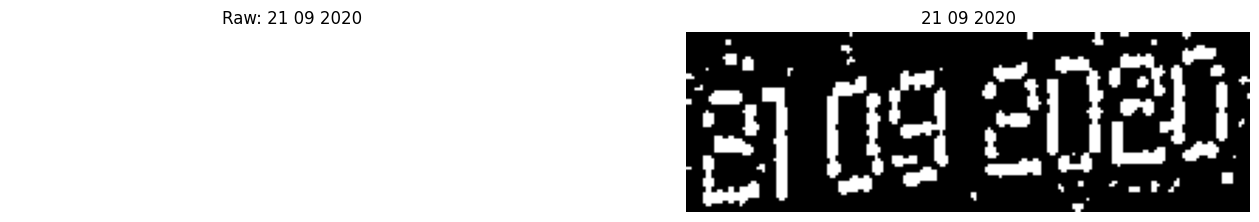

Loading images: 100%|██████████| 1/1 [00:00<00:00,  4.54it/s]


In [6]:
target_size = (32, 100)

for idx, file in enumerate(tqdm(os.listdir(PATH)[:1], total=1, desc="Loading images")):
    file_path = os.path.join(PATH, file)

    image = tf.keras.preprocessing.image.load_img(file_path, color_mode='rgb', target_size=target_size)
    image = tf.keras.preprocessing.image.img_to_array(image)

    preprocessed = preprocess_image(image, resize= True)
    preprocessed = np.expand_dims(preprocessed, axis= -1)
    
    label = get_y_from_json(file)

    plt.figure(figsize=(16, 9))

    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title(f'Raw: {label}')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(preprocessed, cmap='gray')
    plt.title(label)
    plt.axis('off')
    
    plt.show()

Loading images: 100%|██████████| 11840/11840 [00:13<00:00, 868.85it/s]


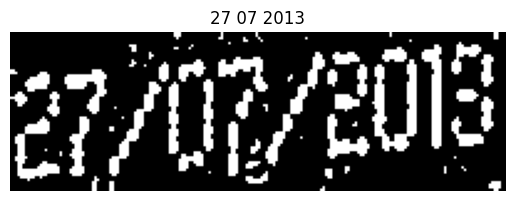

In [7]:
# Load dataset

X = []
Y = []

target_size = (32, 100)

n = 11840

for idx, file in enumerate(tqdm(os.listdir(PATH)[:n], total=n, desc="Loading images")):

    file_path = os.path.join(PATH, file)

    image = tf.keras.preprocessing.image.load_img(file_path, color_mode='rgb', target_size=target_size)
    image = tf.keras.preprocessing.image.img_to_array(image)
    
    image = preprocess_image(image, resize= True)
    image = np.expand_dims(image, axis= -1)

    label = get_y_from_json(file)

    if label != " ":
        X.append(image)
        Y.append(label)

X = np.array(X)
Y = np.array(Y)
    
plt.imshow(X[100], cmap='gray')
plt.title(Y[100])
plt.axis('off')
plt.show()

In [8]:
# Normalized

X_normalized = X / 255.0

print(f'X shape: {X_normalized.shape} | Y shape: {Y.shape}')
print(f'X_normalized[0]: {X_normalized[0]} | Y[0]: {Y[0]}')

X shape: (11840, 64, 200, 1) | Y shape: (11840,)
X_normalized[0]: [[[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 ...

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]] | Y[0]: 21 09 2020


In [9]:
# Encode

char_list = string.ascii_letters + string.digits + ' ' # Digits because only for expiration date

index_to_char = {idx: character for idx, character in enumerate(char_list)}

def encode_label(label: str) -> list:
    
    encoded = []

    for char in label:
        try:
            encoded.append(char_list.index(char))
        except:
            print(f'Not found in char_list: {char}')

    return encoded

def decode_label(encoded) -> list:
        
    decoded = []

    for char_idx in encoded:
        
        if int(char_idx) != -1 and int(char_idx) != len(char_list): # -1 -> _ in CTC and len(char_list) -> pad
            
            decoded.append(index_to_char[char_idx])
                
    return decoded

def preprocess_label(Y):
    
    Y_encoded = [encode_label(label) for label in Y]
    max_len = max(len(seq) for seq in Y_encoded)
    Y_padded = tf.keras.preprocessing.sequence.pad_sequences(Y_encoded, maxlen= max_len, padding='post', value=len(char_list))
    
    return Y_padded


In [10]:
# Pad sequence

Y_padded = preprocess_label(Y)

In [11]:
# Split

X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y_padded, test_size= 0.2, random_state=42)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size= 0.5, random_state=42)

In [12]:
# Define input shape


input_shape = X[0].shape

input_shape

(64, 200, 1)

In [13]:
class MapToSequenceLayer(tf.keras.layers.Layer):

    def __call__(self, inputs):

        # Input = (batch_size, height, width, channels) => Feature Map

        batch_size = tf.shape(inputs)[0]
        height = tf.shape(inputs)[1]
        width = tf.shape(inputs)[2]
        channels = tf.shape(inputs)[3]


        # Output = (batch_size, width, height * channels) => sequence per columns

        outputs = tf.reshape(inputs, (batch_size, width, height * channels))

        return outputs
    
    def get_config(self):
        config = super(MapToSequenceLayer, self).get_config()
        return config

In [14]:
class CTCLoss(tf.keras.losses.Loss):

    def __init__(self, name: str = 'CTCLoss') -> None:

        super(CTCLoss, self).__init__()
        self.name = name
        self.loss_fn = tf.keras.backend.ctc_batch_cost

    def __call__(self, y_true: tf.Tensor, y_pred: tf.Tensor, sample_weight= None) -> tf.Tensor:

        batch_len = tf.cast(tf.shape(y_true)[0], dtype='int64')
        input_length = tf.cast(tf.shape(y_pred)[1], dtype='int64')
        label_length = tf.cast(tf.shape(y_true)[1], dtype='int64')

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype='int64')
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype='int64')

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)

        return loss
    
    def get_config(self):
        config = super(CTCLoss, self).get_config()
        return config


In [15]:
# Model

def create_model(LR = 0.001):

    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=input_shape),
        tf.keras.layers.Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
        tf.keras.layers.Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
        tf.keras.layers.Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu'),
        tf.keras.layers.Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 1)),
        tf.keras.layers.Conv2D(512, kernel_size=(3, 3), padding='same', activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(512, kernel_size=(3, 3), padding='same', activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 1)),
        tf.keras.layers.Conv2D(512, kernel_size=(2, 2), padding='valid', activation='relu'),
        MapToSequenceLayer(),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences=True)),
        tf.keras.layers.Dense(len(char_list) + 1, activation='softmax')
    ])

    model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate= LR), loss= CTCLoss())

    return model

LR = 0.0003

model = create_model(LR)

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 200, 64)       640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 100, 64)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 100, 128)      73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 50, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 50, 256)       295168    
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 50, 256)       5

In [16]:
print(Y_train[0])
print(len(char_list) + 1)
print(model.output_shape)


[52 54 62 29 30 28 62 54 59 63 63]
64
(None, 49, 64)


In [17]:
BATCH_SIZE = 16
EPOCHS = 20

early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=3,           
    mode='min',           
    verbose=1,            
)

history = model.fit(X_train, Y_train, 
          validation_data= (X_val, Y_val), 
          batch_size= BATCH_SIZE, 
          epochs= EPOCHS,
          callbacks=[early_stopping_cb])


Epoch 1/20
 80/592 [===>..........................] - ETA: 46s - loss: 31.9003

KeyboardInterrupt: 

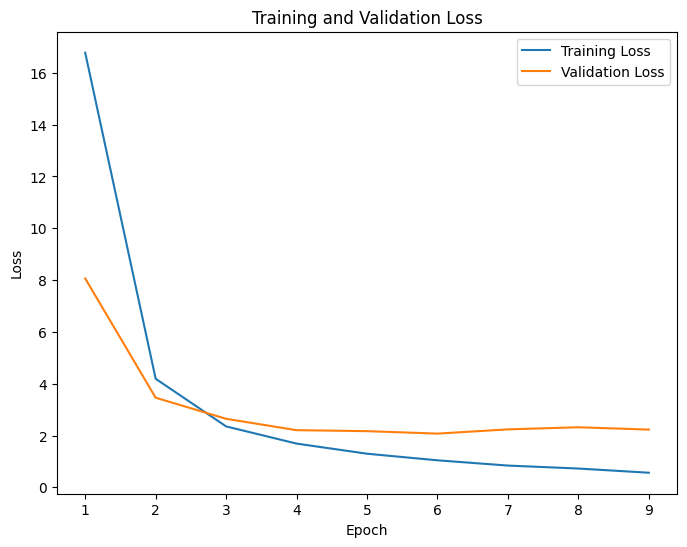

In [37]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 6))
plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')

plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [38]:
# model.save_weights('latest_model_weights.h5')

In [20]:
def character_accuracy(pred_text, truth_text):
    correct_chars = sum([1 for p, t in zip(pred_text, truth_text) if p == t])
    return correct_chars / len(truth_text) if len(truth_text) > 0 else 0.0

def exact_match_accuracy(pred_text, truth_text):
    return 1 if pred_text == truth_text else 0

def character_error_rate(pred_text, truth_text):
    distance = Levenshtein.distance(pred_text, truth_text)
    return distance / max(len(truth_text), 1)

def manual_evaluate(Y_pred, Y_test):

    ctc_input_length = np.ones(Y_pred.shape[0]) * Y_pred.shape[1]
    output = get_value(ctc_decode(Y_pred, input_length= ctc_input_length, greedy= True)[0][0])
    
    correct_char_count = 0
    exact_match_count = 0
    total_cer = 0.0
    total_samples = Y_pred.shape[0] 

    for idx in range(total_samples):
        pred_text = ''.join([char.lower() if char.isalpha() else char for char in decode_label(output[idx])])
        truth_text = ''.join([char.lower() if char.isalpha() else char for char in decode_label(Y_test[idx])])


        char_acc = character_accuracy(pred_text, truth_text)
        exact_acc = exact_match_accuracy(pred_text, truth_text)
        cer = character_error_rate(pred_text, truth_text)

        correct_char_count += char_acc
        exact_match_count += exact_acc
        total_cer += cer


    avg_char_accuracy = correct_char_count / total_samples
    avg_exact_accuracy = exact_match_count / total_samples
    avg_cer = total_cer / total_samples

    print(f"Samples: {total_samples} | Correct: {exact_match_count}")
    print(f"Average character-level accuracy: {avg_char_accuracy:.4f}")
    print(f"Average exact match accuracy: {avg_exact_accuracy}")
    print(f"Average character error rate (CER): {avg_cer:.4f}")

    return output, avg_char_accuracy, avg_exact_accuracy, avg_cer
    
from datetime import datetime

def format_to_datestring(date_str):
    date_formats = [
        "%Y %m %d",    
        "%d %m %Y",   
        "%m/%d/%Y",
        "%d/%m/%Y", 
        "%Y-%m-%d",
        "%d-%m-%Y",
    ]
    
    for date_format in date_formats:
        try:
            date_obj = datetime.strptime(date_str, date_format)
            formatted_date = date_obj.strftime("%d %B %Y")
            return formatted_date
        except ValueError:
            continue
    
    return date_str

In [22]:
model = create_model()
model.load_weights('../crnn_best_model.h5')

37/37 [==============================] - 3s 39ms/step
Samples: 1184 | Correct: 975
Average character-level accuracy: 0.9274
Average exact match accuracy: 0.8234797297297297
Average character error rate (CER): 0.0396


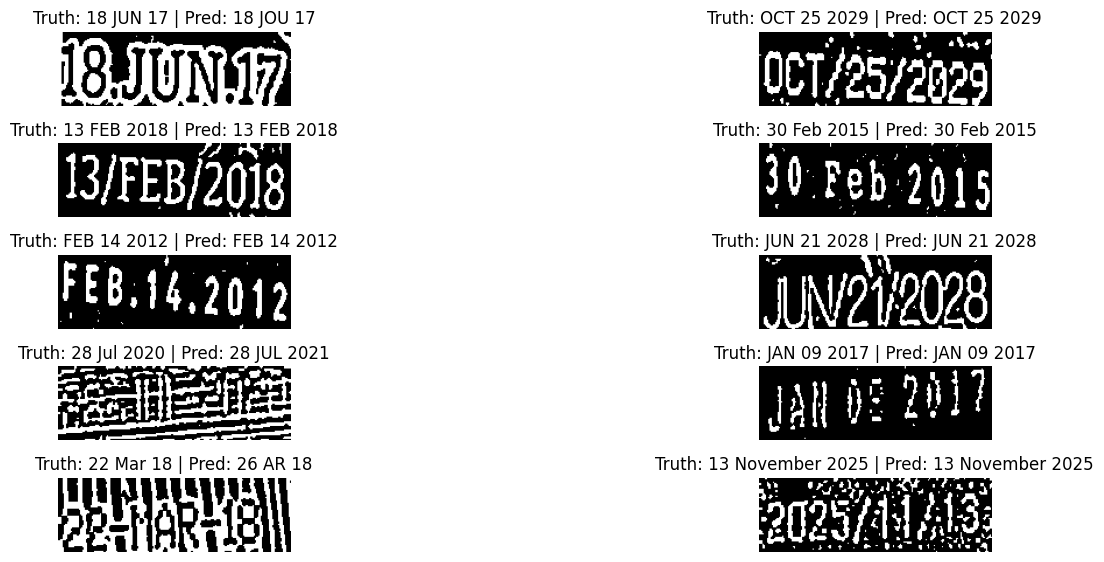

In [23]:
Y_pred = model.predict(X_test)

output, _, _, _ = manual_evaluate(Y_pred, Y_test)

n_sample = 10

plt.figure(figsize=(16, 14))
for idx in range(n_sample):
    pred_text = ''.join([char for char in decode_label(output[idx])])
    truth_text = ''.join([char for char in decode_label(Y_test[idx])])
    
    plt.subplot(n_sample, 2, idx + 1)
    plt.imshow(X_test[idx], cmap='gray')
    plt.title(f'Truth: {format_to_datestring(truth_text)} | Pred: {format_to_datestring(pred_text)}')
    plt.axis('off')

    # print(f'Truth: {format_to_datestring(truth_text)} | Pred: {format_to_datestring(pred_text)}')
plt.subplots_adjust(hspace=0.5, wspace=0.3)
plt.show()

Test with Real Data

In [24]:
REAL_PATH = '../dataset/Date-Real/images/'
REAL_ANNOTATIONS_PATH = '../dataset/Date-Real/annotations.json'

with open(REAL_ANNOTATIONS_PATH, 'r') as file:
    data = json.load(file)

def get_y_from_json(file: str) -> str:
    return " ".join(annotation['transcription'] for annotation in data[file]['ann'])

Loading images: 100%|██████████| 510/510 [00:00<00:00, 974.67it/s] 


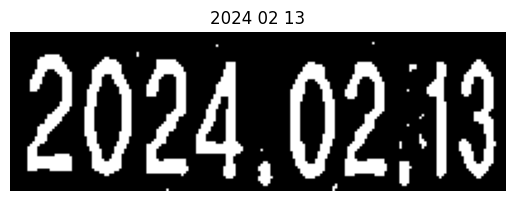

In [25]:
# Load dataset

X_real = []
Y_real = []

target_size = (32, 100)

n = 510

for idx, file in enumerate(tqdm(os.listdir(REAL_PATH)[:n], total=n, desc="Loading images")):

    file_path = os.path.join(REAL_PATH, file)

    image = tf.keras.preprocessing.image.load_img(file_path, color_mode='rgb', target_size=target_size)
    image = tf.keras.preprocessing.image.img_to_array(image)
    
    image = preprocess_image(image, resize= True)
    image = np.expand_dims(image, axis= -1)

    label = get_y_from_json(file)

    if label != " ":
        X_real.append(image)
        Y_real.append(label)

X_real = np.array(X_real)
Y_real = np.array(Y_real)
    
plt.imshow(X_real[100], cmap='gray')
plt.title(Y_real[100])
plt.axis('off')
plt.show()

Y_padded_real = preprocess_label(Y_real)

In [43]:
print(f'Input shape: {X_real.shape}')

Input shape: (510, 64, 200, 1)


16/16 [==============================] - 2s 42ms/step
Samples: 510 | Correct: 420
Average character-level accuracy: 0.9354
Average exact match accuracy: 0.8235294117647058
Average character error rate (CER): 0.0405


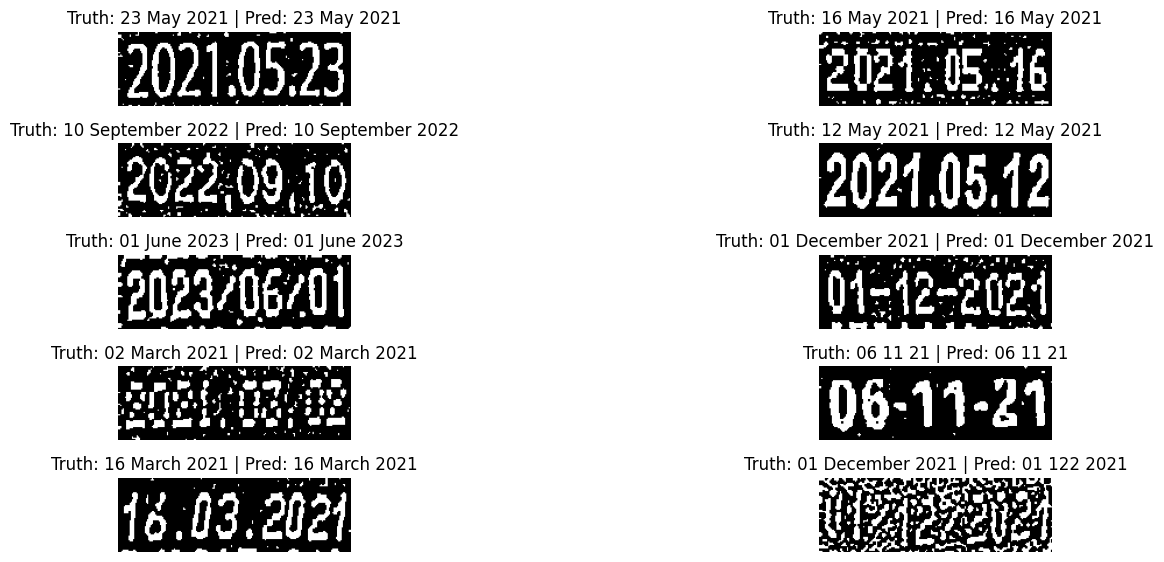

In [27]:
# Use saved model

saved_model = create_model()
saved_model.load_weights('../crnn_best_model.h5')

Y_pred = saved_model.predict(X_real)

output, _, _, _ = manual_evaluate(Y_pred, Y_padded_real)

n_sample = 10

plt.figure(figsize=(16, 14))
for idx in range(n_sample):
    pred_text = ''.join([char for char in decode_label(output[idx])])
    truth_text = ''.join([char for char in decode_label(Y_padded_real[idx])])
    
    plt.subplot(n_sample, 2, idx + 1)
    plt.imshow(X_real[idx], cmap='gray')
    plt.title(f'Truth: {format_to_datestring(truth_text)} | Pred: {format_to_datestring(pred_text)}')
    plt.axis('off')

    # print(f'Truth: {format_to_datestring(truth_text)} | Pred: {format_to_datestring(pred_text)}')
plt.subplots_adjust(hspace=0.5, wspace=0.3)
plt.show()